Universidade Estadual de Campinas – UNICAMP 

Disciplina: Ciência e Visualização de Dados em Saúde

                    Análise de dados da hanseníase: uma abordagem preditiva para a saúde pública

# Imports e configs de módulos

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import imageio
from IPython.display import Image
import warnings
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 70)
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.005)
warnings.filterwarnings('ignore')

# Datasets

In [4]:
df_hans = pd.read_csv('../data/interim/hans_pre_covid.csv')

In [5]:
df_hans.head()

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODODETECT,BACILOSCOP,DTINICTRAT,ESQ_INI_N,UFATUAL,ID_MUNI_AT,DT_NOTI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N
0,29.0,292700,1382.0,2653257.0,27/11/2008,1958.0,M,6.0,4.0,3.0,29.0,292700.0,1382.0,NaN,2.0,3.0,1.0,2.0,3.0,02/03/2009,1.0,BA,292700.0,01/01/2009,2653257.0,29.0,292700.0,1.0,3.0,1.0,4.0,2009,1.0,4.0,6.0,NaN,29/12/2009,1.0
1,21.0,210330,1434.0,2449706.0,01/01/2009,1943.0,M,6.0,4.0,1.0,21.0,210330.0,1434.0,NaN,4.0,1.0,2.0,1.0,1.0,23/10/2009,2.0,MA,210330.0,01/01/2009,2449706.0,21.0,210330.0,2.0,1.0,2.0,4.0,2009,10.0,6.0,12.0,1.0,22/09/2010,1.0
2,26.0,260290,1497.0,20389.0,13/10/2008,1994.0,F,9.0,NaN,NaN,26.0,260290.0,1497.0,999991.0,1.0,0.0,1.0,1.0,2.0,13/10/2008,1.0,PE,260290.0,02/01/2009,20389.0,26.0,260290.0,1.0,NaN,1.0,NaN,2009,1.0,3.0,NaN,3.0,22/05/2009,1.0
3,21.0,211290,1432.0,2455706.0,02/01/2009,1957.0,M,6.0,1.0,2.0,21.0,211290.0,1432.0,NaN,4.0,3.0,2.0,2.0,1.0,02/01/2009,2.0,MA,211290.0,02/01/2009,2455706.0,21.0,211290.0,2.0,3.0,2.0,4.0,2009,2.0,6.0,12.0,1.0,29/04/2010,1.0
4,35.0,354350,1575.0,2053381.0,18/12/2008,1968.0,M,6.0,1.0,1.0,35.0,354350.0,1575.0,NaN,1.0,0.0,2.0,1.0,1.0,18/12/2008,2.0,SP,354350.0,02/01/2009,2053381.0,35.0,354350.0,2.0,1.0,2.0,4.0,2009,1.0,2.0,NaN,2.0,18/12/2009,1.0


In [6]:
df_hans.shape

(309555, 38)

In [160]:
# Remove datas inconsistentes

try:
  df_hans['DTINICTRAT'] = pd.to_datetime(df_hans['DTINICTRAT'])
  df_hans['DTALTA_N'] = pd.to_datetime(df_hans['DTALTA_N'])
except ValueError:
    df_hans['DTINICTRAT'] = pd.to_datetime(df_hans['DTINICTRAT'], errors='coerce')
    df_hans['DTALTA_N'] = pd.to_datetime(df_hans['DTALTA_N'], errors='coerce')

df_hans['DURACAO_TRAT'] = (df_hans['DTALTA_N'] - df_hans['DTINICTRAT']).dt.days
df_hans = df_hans[df_hans['DURACAO_TRAT'] >= 0]

# EDA

### Análise de casos por estado

In [7]:
df_hans_states = df_hans['UFATUAL'].value_counts().to_frame().reset_index()
df_hans_states = df_hans_states.rename(columns={'index': 'UF', 'UFATUAL': 'Contagem'})
df_hans_states.head()

,UF,Contagem
0,MA,36401
1,PA,30764
2,MT,30068
3,PE,25421
4,BA,23579


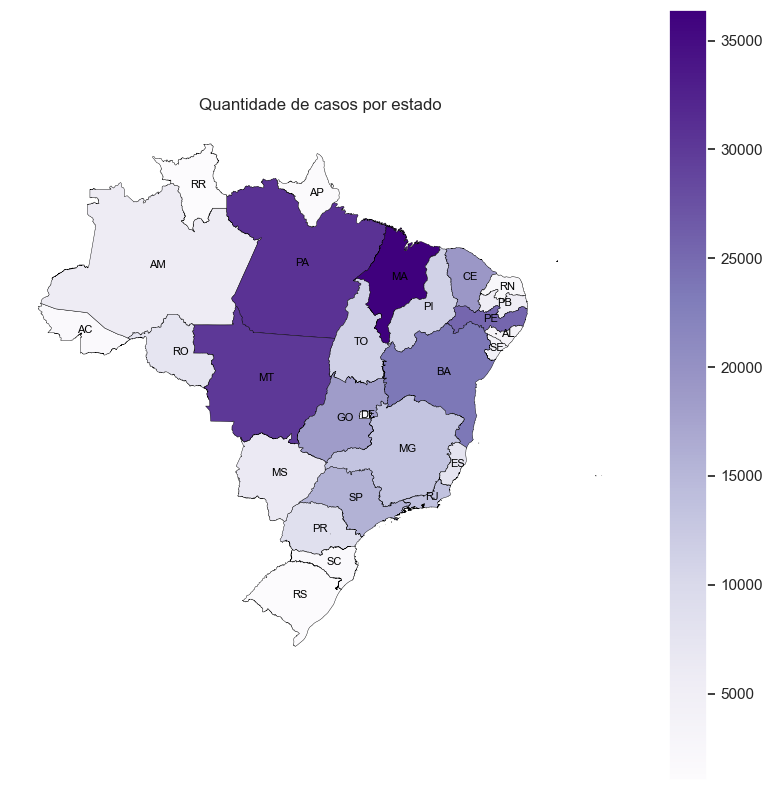

In [8]:
# Carrega o arquivo shapefile do mapa do Brasil
map = gpd.read_file('../assets/mapa/BR_UF_2022.shp')

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences = map.merge(df_hans_states, left_on='SIGLA_UF', right_on='UF')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos por estado')
ax.set_axis_off()
plt.show()

### Análise de casos por estado e por ano

In [9]:
df_hans_states_per_year = df_hans[['UFATUAL', 'NU_ANO']].value_counts().to_frame().reset_index()
df_hans_states_per_year = df_hans_states_per_year.rename(columns={'UFATUAL': 'UF', 0: 'Contagem'})
df_hans_states_per_year.head()

,UF,NU_ANO,Contagem
0,MT,2018,4058
1,MT,2019,3881
2,MA,2009,3816
3,MA,2010,3779
4,PA,2009,3697


In [43]:
years_analysis = df_hans_states_per_year['NU_ANO'].unique()
years_analysis.sort()

vmax=df_hans_states_per_year['Contagem'].max()

In [44]:
for i in range(len(years_analysis)):
    year = years_analysis[i]
    # Combina o DataFrame com o GeoDataFrame do mapa
    map_occurrences = map.merge(df_hans_states_per_year[df_hans_states_per_year['NU_ANO']==year], left_on='SIGLA_UF', right_on='UF')
    map_occurrences.drop(['NU_ANO'], axis=1, inplace=True)
    map_occurrences.fillna(0, inplace=True)

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, vmin=0, vmax=vmax)

    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    ax.set_title('Quantidade de casos por estado em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for i in range(len(years_analysis)):
    year = years_analysis[i]
    nome_arquivo = f'../assets/graficos/mapa_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos.gif', imagens, fps=2)

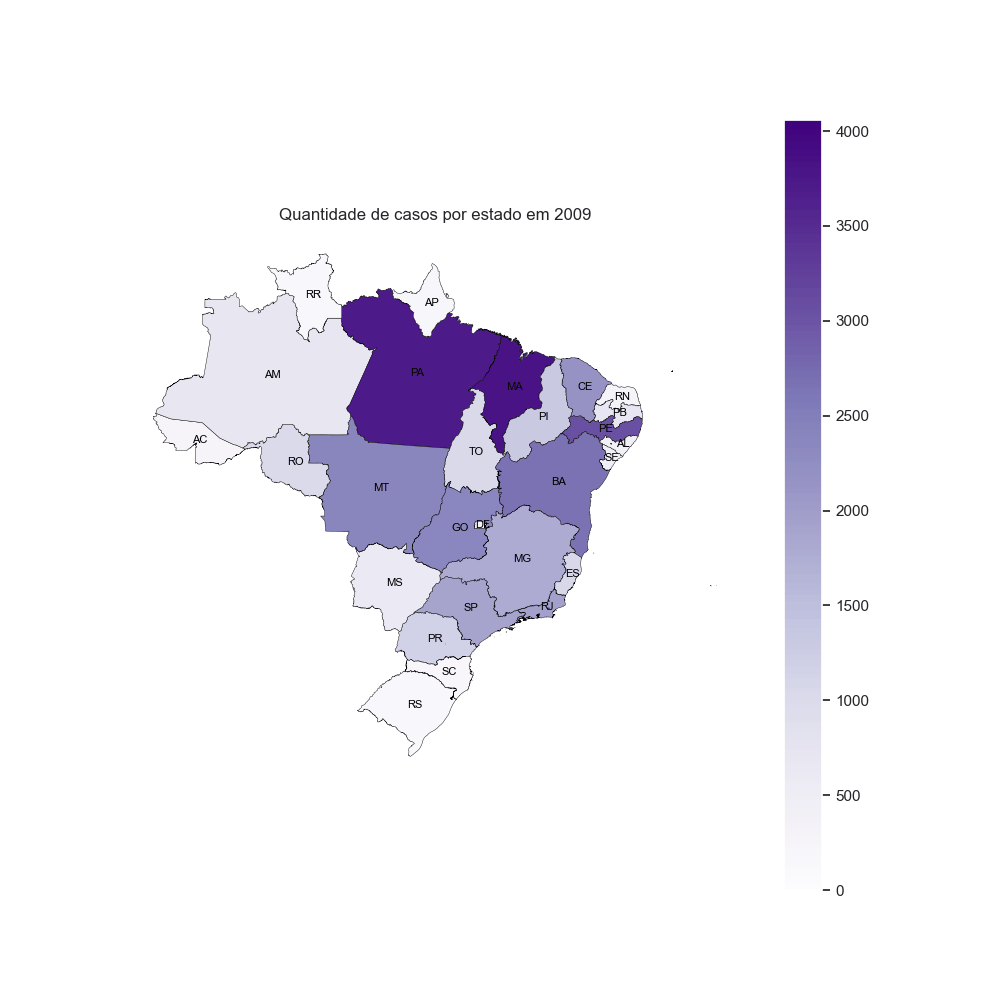

In [45]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos.gif')


### Correlação da quantidade de casos e o IDH dos estados

#### 1. Sem remover outliers

In [150]:
df_idh = pd.read_csv('../data/interim/idh_interim.csv')
df_idh['IDH'] = df_idh['IDH'].astype(float)
df_idh.head()

,UF,NU_ANO,IDH
0,AC,2009,0.663
1,AL,2009,0.631
2,AP,2009,0.708
3,AM,2009,0.674
4,BA,2009,0.660


In [151]:
df_hans_idh = pd.merge(df_hans_states_per_year, df_idh, on=['UF', 'NU_ANO'], how='inner')
df_hans_idh.head()

,UF,NU_ANO,Contagem,IDH
0,MT,2018,4058,0.778
1,MT,2019,3881,0.779
2,MA,2009,3816,0.639
3,MA,2010,3779,0.639
4,PA,2009,3697,0.646


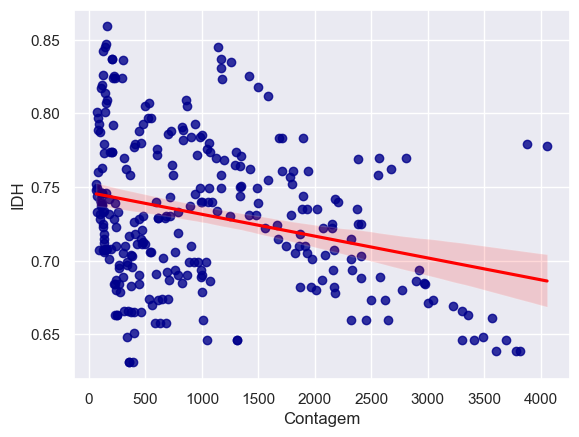

In [158]:
# Cria o gráfico de dispersão com linha de regressão
sns.regplot(x='Contagem', y='IDH', data=df_hans_idh, color='darkblue', line_kws={'color': 'red'})

# Exibe o gráfico
plt.show()

In [153]:
# Calcule a correlação entre as variáveis
correlation = df_hans_idh['Contagem'].corr(df_hans_idh['IDH'])
# Imprima o resultado
print('Correlação:', correlation)

# Calcule a covariância entre as variáveis
covariance = df_hans_idh['Contagem'].cov(df_hans_idh['IDH'])
# Imprima o resultado
print('Covariância:', covariance)


Correlação: -0.2785585283229319
Covariância: -13.42977774365274


#### 2. Removendo outliers

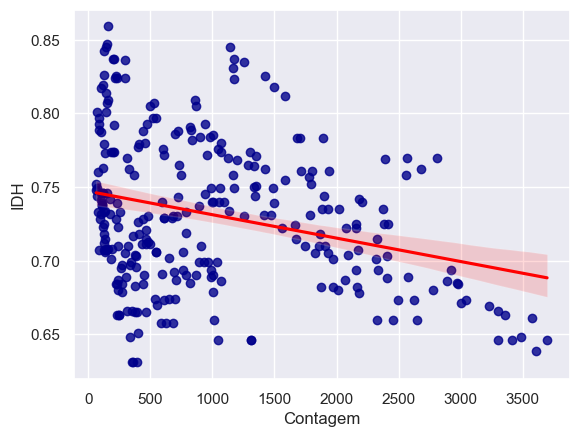

In [154]:
def remove_outliers_boxplot(data_column):
    # Calcula os limites do boxplot
    q1 = data_column.quantile(0.25)
    q3 = data_column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filtra os valores que estão dentro dos limites
    filtered_data = data_column[(data_column >= lower_bound) & (data_column <= upper_bound)]

    return filtered_data

filtered_data = remove_outliers_boxplot(df_hans_idh)

# Cria o gráfico de dispersão com linha de regressão
sns.regplot(x='Contagem', y='IDH', data=filtered_data, color='darkblue', line_kws={'color': 'red'})

# Exibe o gráfico
plt.show()

In [155]:
# Calcule a correlação entre as variáveis
correlation = df_hans_idh['Contagem'].corr(filtered_data['IDH'])
# Imprima o resultado
print('Correlação:', correlation)

# Calcule a covariância entre as variáveis
covariance = df_hans_idh['Contagem'].cov(filtered_data['IDH'])
# Imprima o resultado
print('Covariância:', covariance)


Correlação: -0.2785585283229319
Covariância: -13.42977774365274


### Análise de casos por estado e gravidade

In [13]:
df_hans_severity = df_hans.groupby(['UFATUAL', 'AVALIA_N']).size().reset_index(name='Contagem')
df_hans_severity.head()

,UFATUAL,AVALIA_N,Contagem
0,AC,0.0,1347
1,AC,1.0,290
2,AC,2.0,93
3,AC,3.0,21
4,AL,0.0,1967


#### Grau 0:

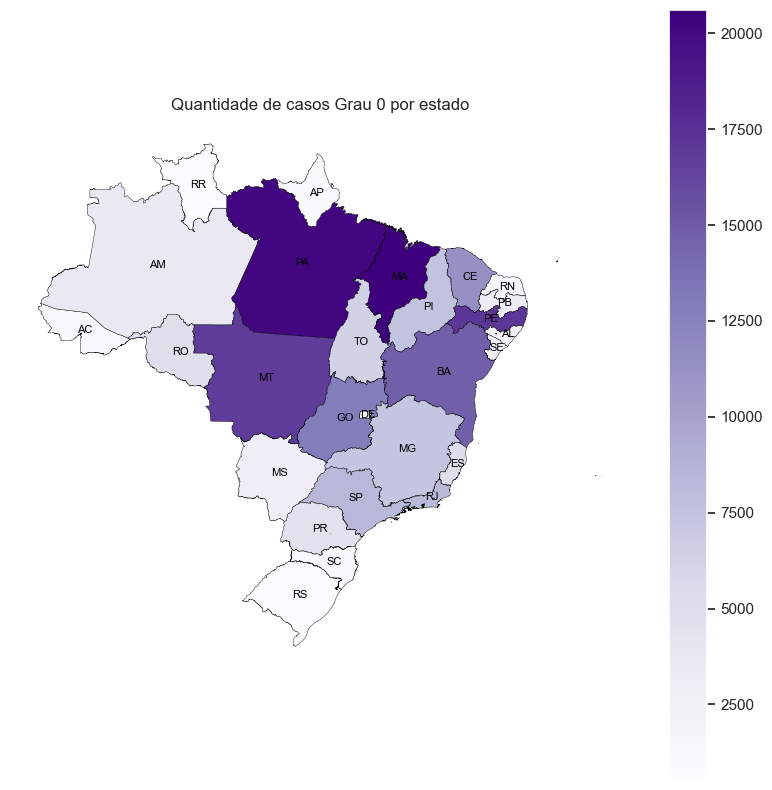

In [14]:
df_hans_severity_0 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 0].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_0 = map.merge(df_hans_severity_0, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_0.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau 0 por estado')
ax.set_axis_off()
plt.show()

#### Grau I:

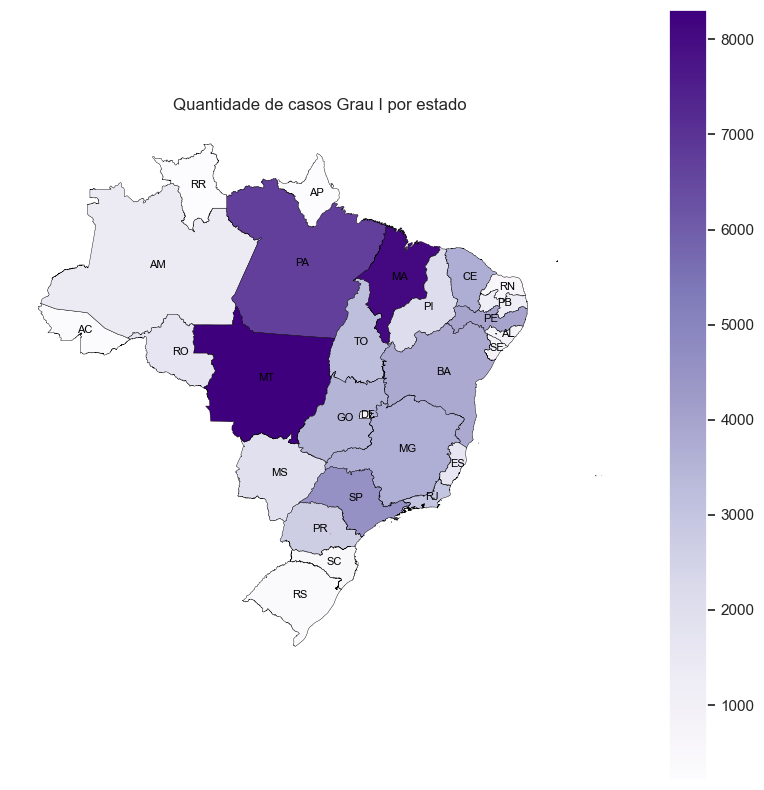

In [15]:

df_hans_severity_1 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 1].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_1 = map.merge(df_hans_severity_1, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_1.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau I por estado')
ax.set_axis_off()
plt.show()

#### Grau II:

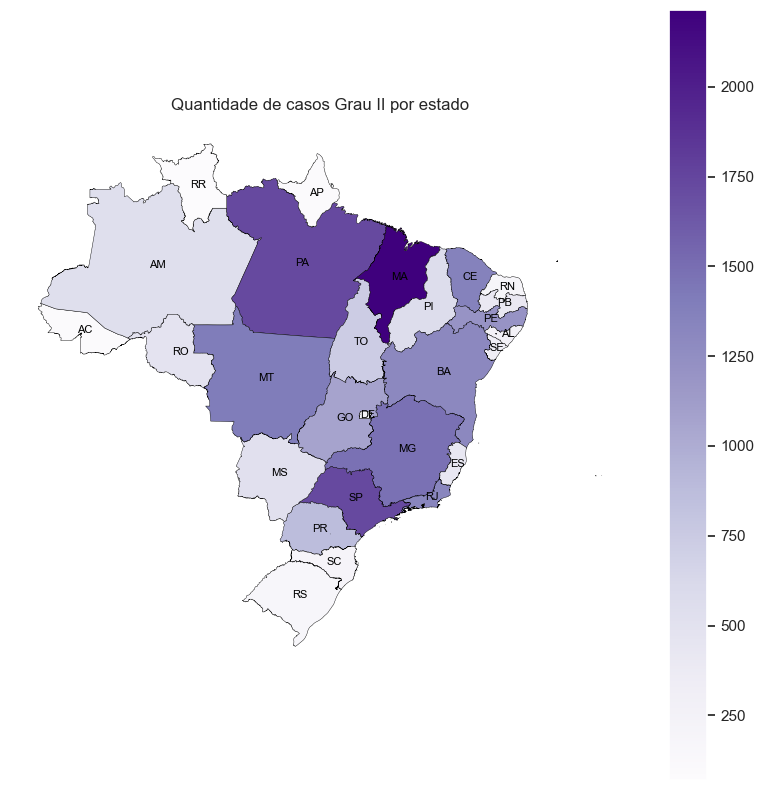

In [16]:
df_hans_severity_2 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 2].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_2 = map.merge(df_hans_severity_2, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_2.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau II por estado')
ax.set_axis_off()
plt.show()

### Análise do abandono

In [17]:
# Considerar apenas casos com desfecho: cura, óbito ou abandono
df_hans_tp_alta = df_hans[df_hans['TPALTA_N'].isin([1, 6, 7])]

<AxesSubplot:>

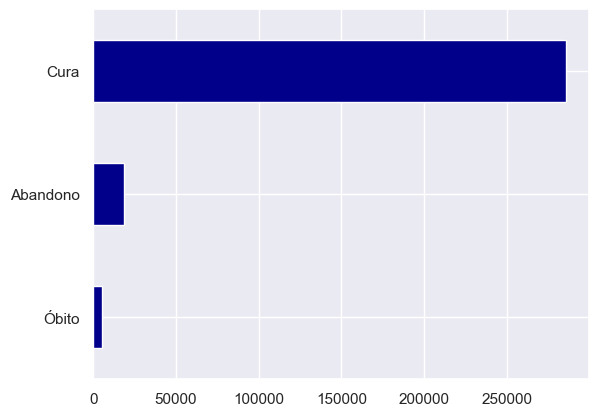

In [18]:
df_hans_outcome = df_hans_tp_alta.copy()
df_hans_outcome['TPALTA_N'] = df_hans_outcome['TPALTA_N'].replace({1: 'Cura', 6: 'Óbito', 7: 'Abandono'})
df_hans_outcome['TPALTA_N'].value_counts().sort_values().plot.barh(color='darkblue')

In [19]:
# Agrupa os dados pelo ano e pelo munícipio da ultima atualização
gp_muni_at = df_hans.groupby(["NU_ANO", "ID_MUNI_AT"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_muni_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_muni_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
NU_ANO ID_MUNI_AT                                
2009   110001.0         40          0    0.000000
       110002.0         77          0    0.000000
       110003.0          1          0    0.000000
       110004.0         42          3    0.071429
       110005.0         11          2    0.181818
...                    ...        ...         ...
2019   522160.0         11          1    0.090909
       522170.0          2          0    0.000000
       522180.0          1          0    0.000000
       522205.0          5          1    0.200000
       530010.0        161         23    0.142857

[30205 rows x 3 columns]

In [20]:
# Leitura dos polígonos das cidades brasileiras de uma cópia local
geo = gpd.read_file("../assets/mapa/all_cities.shp")
# Adapta o código das cidades do ibge para a versão utilizada pelo ministério da saúde 
geo["muni"] = geo["code_muni"].astype("string").str.slice(stop=-3).astype("float64")

for year in years_analysis:
    # Combina as contagens de abandono por cidade com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["muni"], right_on=["ID_MUNI_AT"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.1, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6}
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab.gif', imagens, fps=2)

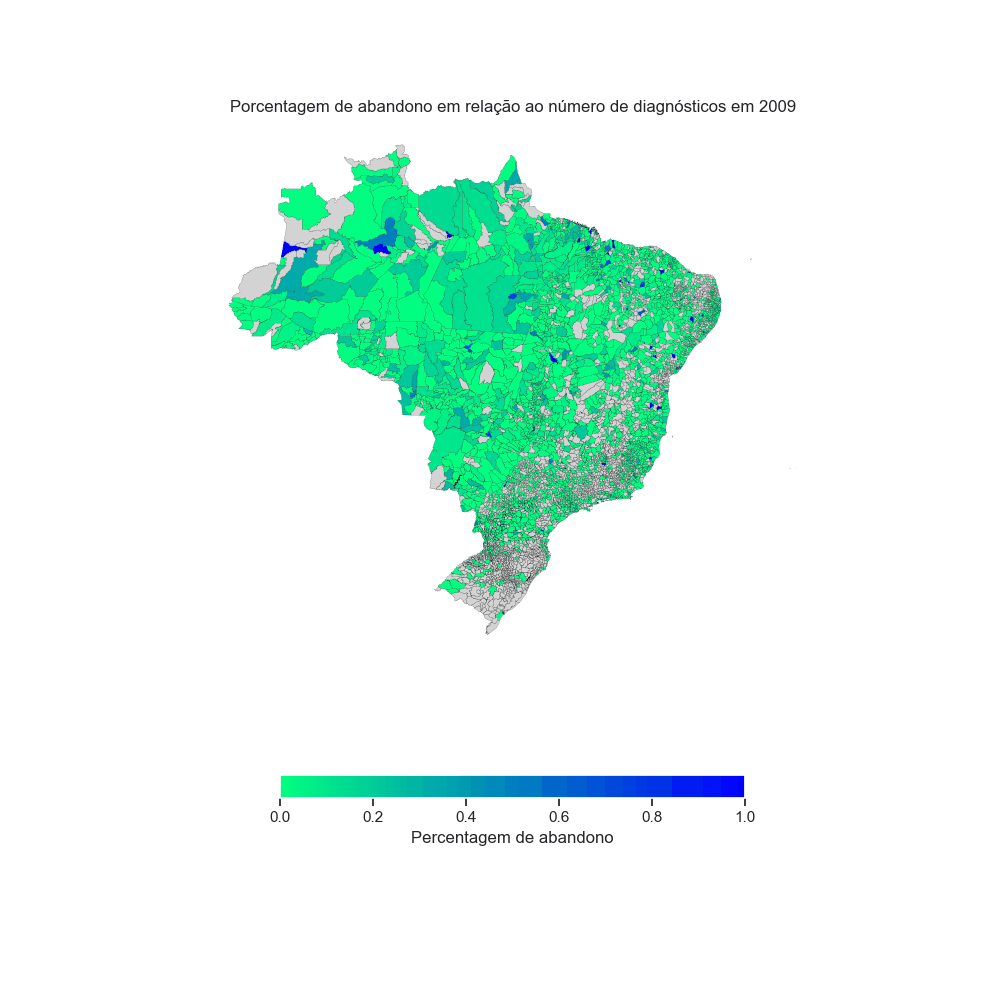

In [62]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab.gif')

In [ ]:
# Agrupar abandonos por estado
gp_uf_at = df_hans.groupby(["NU_ANO", "UFATUAL"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_uf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_uf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

In [ ]:
# Leitura dos polígonos dos estados brasileiros de uma cópia local
geo = gpd.read_file("../assets/mapa/BR_UF_2022.shp")

# Max e Min dos valores
vmin = min(count_df["PERCENT_AB"])
vmax = max(count_df["PERCENT_AB"])

for year in years_analysis:    
    # Combina as contagens de abandono por estado com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["SIGLA_UF"], right_on=["UFATUAL"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    heatmap = map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6},
        vmin=vmin, vmax=vmax
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_uf_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_uf_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab_uf.gif', imagens, fps=2)

In [ ]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab_uf.gif')

In [ ]:
# Agrupar abandonos por sexo
gp_mf_at = df_hans.groupby(["NU_ANO", "CS_SEXO"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_mf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_mf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = (count_ab/count_diag)*100
count_df = count_df.drop('I', level='CS_SEXO')
count_df

In [ ]:
years = count_df.index.get_level_values('NU_ANO').unique()
sexes = count_df.index.get_level_values('CS_SEXO').unique()

bar_width = 0.35
r = np.arange(len(years))
spacing = [0.15-bar_width, -0.15+bar_width]
colors = [['lightcoral', 'firebrick'], ['c', 'royalblue']]
legend_handles = list()

for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        aband_bar = plt.bar(r[i] + spacing[j], 
                            count_df['ABANDONOS'].loc[year, sex], 
                            width=bar_width, color=colors[j][1],
                            label=f"Abandonos {sex}")
        legend_handles.append(aband_bar[0])
        
        diag_bar = plt.bar(r[i] + spacing[j], 
                           count_df['DT_DIAG'].loc[year, sex], 
                           width=bar_width, color=colors[j][0], 
                           label=f"Diagnóstico {sex}",
                           bottom=count_df['ABANDONOS'].loc[year, sex])
        legend_handles.append(diag_bar[0])
        
        total = count_df['ABANDONOS'].loc[year, sex] + count_df['DT_DIAG'].loc[year, sex]
        plt.text(r[i] + spacing[j], total, 
                 f'{count_df["PERCENT_AB"].loc[year,sex]:.1f}%', 
                 ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Ano")
plt.ylabel("Número de casos")
plt.title("Número de diagnósticos e abandonos por ano e sexo")

plt.xticks(r, years)
plt.legend(handles=legend_handles, labels=['Abandono F',
                                           'Diagnóstico F',
                                           'Abandono M',
                                           'Diagnóstico M'])
plt.savefig('../assets/graficos/graficos_ab_sexo.png')

In [ ]:
df_hans['IDADE'] = df_hans['NU_ANO'] - df_hans['ANO_NASC']
df_hans['FAIXA_ETARIA'] = np.round(df_hans['IDADE']/10)*10
gp_idade = df_hans.groupby(["FAIXA_ETARIA"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_idade['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_idade['DT_DIAG'].count()

count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = (count_ab/count_diag)*100

In [ ]:
years = count_df.index.get_level_values('FAIXA_ETARIA').unique()[0:-2]

bar_width = 0.35
r = np.arange(len(years))
colors = ['lightcoral', 'firebrick']
legend_handles = list()

plt.figure(figsize=(10,10))
for i, year in enumerate(years):
    aband_bar = plt.bar(r[i], 
                        count_df['ABANDONOS'].loc[year], 
                        width=bar_width, color=colors[1],
                        label="Abandonos")
    legend_handles.append(aband_bar[0])
    
    diag_bar = plt.bar(r[i],
                       count_df['DT_DIAG'].loc[year], 
                       width=bar_width, color=colors[0], 
                       label="Diagnósticos",
                       bottom=count_df['ABANDONOS'].loc[year])
    legend_handles.append(diag_bar[0])
    
    total = count_df['ABANDONOS'].loc[year] + count_df['DT_DIAG'].loc[year]
    plt.text(r[i], total, 
             f'{count_df["PERCENT_AB"].loc[year]:.1f}%', 
             ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Faixa Etária")
plt.ylabel("Número de casos")
plt.title("Número de diagnósticos e abandonos por faixa etária")
plt.xticks(r, ['0-9', '10-19', '20-29', '30-39', '40-49',
            '50-59', '60-69', '70-79', '80-89', '90-99', '100-109'])
plt.xticks(rotation=45)

plt.legend(handles=legend_handles, labels=['Abandonos',
                                           'Diagnósticos'])

### Correlação variáveis

#### Tempo de Cura

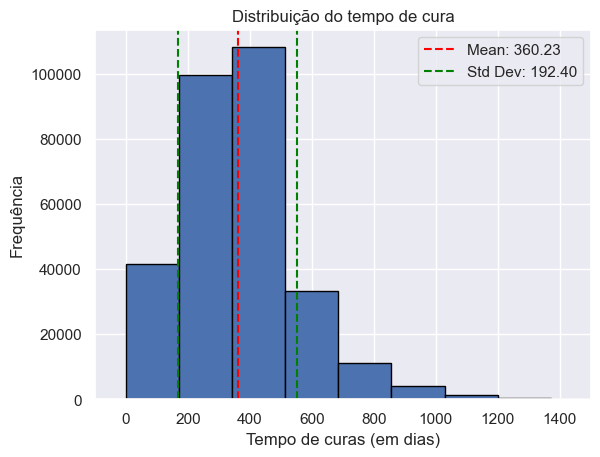

In [161]:
# Análise da distribuição dos tempos de cura
column_name = 'DURACAO_TRAT'
filtered_data = df_hans[df_hans[column_name] >= 0][column_name]

mean = np.mean(filtered_data)
std_dev = np.std(filtered_data)


plt.hist(filtered_data, bins=50, edgecolor='black')
plt.xlabel('Tempo de curas (em dias)')
plt.ylabel('Frequência')
plt.title('Distribuição do tempo de cura')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean:.2f}')
plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1.5, label=f'Std Dev: {std_dev:.2f}')
plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1.5)
plt.legend()

x_min = -100 
x_max = 1500
plt.xlim(x_min, x_max)

plt.show()

In [162]:
column_name = 'DURACAO_TRAT' 
correlation = df_hans.corr()[column_name] 
print(correlation)

SG_UF_NOT       0.048446
ID_MUNICIP      0.048589
ID_REGIONA      0.006948
ID_UNIDADE      0.007425
ANO_NASC       -0.020340
CS_GESTANT      0.014853
CS_RACA         0.000077
SG_UF           0.048856
ID_MN_RESI      0.048988
ID_RG_RESI      0.007361
FORMACLINI      0.290508
AVALIA_N        0.111883
CLASSOPERA      0.382959
MODODETECT     -0.002691
BACILOSCOP     -0.066257
ESQ_INI_N       0.388114
ID_MUNI_AT      0.048562
ID_UNID_AT      0.008595
UFRESAT         0.048560
MUNIRESAT       0.048793
CLASSATUAL      0.397797
AVAL_ATU_N      0.110092
ESQ_ATU_N       0.409938
EPIS_RACIO     -0.109474
NU_ANO          0.057951
NU_LESOES       0.152590
CONTREG         0.011567
DOSE_RECEB      0.456171
CONTEXAM        0.013165
TPALTA_N        0.058920
DURACAO_TRAT    1.000000
Name: DURACAO_TRAT, dtype: float64


#####
Note que as correlações mais altas se dão, em ordem decrescente, com as colunas:

CLASSOPERA (0.461423) - classificação operacional, virável categórica para 1 = paucibacilar, 2 = multibacilar

FORMACLINI (0.366289) - forma clínica da doença, variável categórica para 1 = indeterminada, 2 = tuberculóide, 3 = dimorfa, 4 = virchowiana, 5 = não classficado

NU_LESOES (0.210927) - número de lesões

#### Tipo de Saída

In [66]:
df_hans_outcome = df_hans_outcome[df_hans_outcome['TPALTA_N'] != 'Óbito']

In [67]:
target = 'TPALTA_N'
num_feats = [col for col in df_hans_outcome.columns if df_hans_outcome[col].dtype != 'O']
cat_feats = [col for col in df_hans_outcome.columns if col not in num_feats and col != 'CG']

In [75]:
def cut_cat_features(df, feature, top_n=10, only_top=True, vc_th=5):
    
    vc = df[feature].value_counts()
    vc = vc[vc > vc_th]
    if not only_top:
        return list(vc.index)
    return list(vc.head(top_n).index)

def boxplot_num_cat(df, num_col, cat_col, ax):
    
    df_plot = df[(df[num_col].notna())].copy()
    sns.boxplot(ax=ax, x=cat_col, y=num_col, data=df_plot, showfliers=False)
    
def boxplot_cat_num(df, cat_col, num_col, ax):
    
    df_plot = df[(df[num_col].notna())&\
                 (df[num_col] > 0)].copy()
    top_classes = cut_cat_features(df_plot, cat_col, vc_th=1)
    df_plot = df_plot[df_plot[cat_col].isin(top_classes)]
    sns.boxplot(ax=ax, x=num_col, y=cat_col, data=df_plot, showfliers=False)
    
def stacked_bar_plot(df, feature, target, ax):
    
    df_plot = df.copy()
    top_classes = cut_cat_features(df_plot, feature)
    df_plot = df_plot[df_plot[feature].isin(top_classes)]
    pd.pivot_table(
        df_plot.groupby(feature)[target].value_counts(1).reset_index(level=0).rename(columns={target:'prop'}).reset_index(), 
        values='prop', columns=target, index=feature).plot(kind='barh', stacked=True, legend=False, ax=ax)
    
def scatter_plot(df, feature_col, target_col, ax):
    
    df_plot = df[(df[feature_col].notna())&(df[target_col].notna())&(df[target_col] > 0)]
    sns.scatterplot(x=feature_col, y=target_col, data=df, ax=ax)
        
def make_subplots(df, feature_cols, target_col, count=False):
    
    feature_type = 'cat' if df[feature_cols[0]].dtype == 'O' else 'num'
    target_type = 'cat' if df[target_col].dtype == 'O' else 'num'
    
    if feature_type == target_type == 'cat':
        plot_fn = stacked_bar_plot
        title = 'Stacked Bar Plots'
    elif feature_type == 'cat' and target_type == 'num':
        title = 'Boxplots'
        plot_fn = boxplot_cat_num
    elif feature_type == 'num' and target_type == 'cat':
        title = 'Boxplots'
        plot_fn = boxplot_num_cat
    else:
        title = 'Scatter Plots'
        plot_fn = scatter_plot
        
    n_plots = len(feature_cols)
    n_cols = 3
    n_rows = int(np.ceil(n_plots/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle(title, size=14)
    
    if n_rows == 1:
        idxs = list(range(n_cols))
    else:
        idxs = [(x, y) for x in range(n_rows) for y in range(n_cols)]
    idxs = idxs[:n_plots]
    
    for i, idx in enumerate(idxs):
        plot_fn(df, feature_cols[i], target_col, axes[idx])
        
    if title == 'Stacked Bar Plots':
        handles, labels = axes[idxs[0]].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', title=target_col, 
                   bbox_to_anchor = (0.5, 1.05), bbox_transform = plt.gcf().transFigure)
            
    plt.tight_layout()
    plt.show()
    
def anova(df, cat_col, num_col, target='cat'):
    
    if target != 'cat':
        df_anova = df[(df[num_col].notna())&(df[num_col] > 0)].copy()
        classes_to_keep = cut_cat_features(df_anova, cat_col, only_top=False)
        if not classes_to_keep:
            return np.nan
        df_anova = df_anova[df_anova[cat_col].isin(classes_to_keep)]
    else:
        df_anova = df[(df[num_col].notna())].copy()
    _, p = f_classif(df_anova[num_col].values.reshape(-1, 1), df_anova[cat_col])
    return p[0]

def chi2_test(df, feature, target):
    
    df_chi2 = df.copy()
    classes_to_keep = cut_cat_features(df_chi2, feature, only_top=False)
    if not classes_to_keep:
        return np.nan
    df_chi2 = df_chi2[df_chi2[feature].isin(classes_to_keep)]
    _, p_value, _, _ = chi2_contingency(pd.crosstab(df_chi2[feature], df_chi2[target]))
    return p_value

def corr(df, feature, target):
    
    df_corr = df[(df[feature].notna())&(df[target].notna())&(df[target] > 0)]
    ps = df_corr[[feature, target]].corr().values[0, 1]
    sp = df_corr[[feature, target]].corr(method='spearman').values[0, 1]
    return (ps, sp)

def mutual_info(df, feature_col, target_col, target='cat', feature='cat'):
    
    if target == 'num':
        df_mi = df[(df[target_col].notna())&(df[target_col] > 0)].copy()
        classes_to_keep = cut_cat_features(df_mi, feature_col, only_top=False)
        if not classes_to_keep:
            return np.nan
        df_mi = df_mi[df_mi[feature_col].isin(classes_to_keep)]
        
        X = df_mi[[target_col]]
        y = df_mi[feature_col]
        discrete_features = False
    elif target == 'cat' and feature == 'num':
        df_mi = df[(df[feature_col].notna())].copy()
        
        X = df_mi[[feature_col]]
        y = df_mi[target_col]
        discrete_features = False
    else:
        df_mi = df.copy()
        classes_to_keep = cut_cat_features(df_mi, feature_col, only_top=False)
        if not classes_to_keep:
            return np.nan
        df_mi = df_mi[df_mi[feature_col].isin(classes_to_keep)]
        
        X = LabelEncoder().fit_transform(df_mi[feature_col]).reshape(-1, 1)
        y = df_mi[target_col]
        discrete_features = True
        
    mi = mutual_info_classif(X, y, discrete_features=discrete_features)
    return mi[0]

def p_value_color(val):
    if pd.isnull(val):
        return 'background-color: gray'
    elif val < 1e-2:
        return 'background-color: blue'
    elif val < 5e-2:
        return 'background-color: green'
    elif val < 1e-1:
        return 'background-color: yellow'
    elif val < 5e-1:
        return 'background-color: orange'
    else:
        return 'background-color: red'
    
def corr_color(val):
    if val < 0.3 and val > -0.3:
        return 'background-color: yellow'
    elif val < 0.7 and val > -0.7:
        return 'background-color: green'
    else:
        return 'background-color: blue'

def get_correlations(df, feature_cols, target_col):
    
    feature_type = 'cat' if df[feature_cols[0]].dtype == 'O' else 'num'
    target_type = 'cat' if df[target_col].dtype == 'O' else 'num'
    
    if feature_type == 'cat' and target_type == 'cat':
        chi2_values = [chi2_test(df, feature, target_col) for feature in feature_cols]
        mi_values = [mutual_info(df, feature, target_col) for feature in feature_cols]
        values = [chi2_values, mi_values]
        index = ['chi2_p_value', 'M.I']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T.sort_values('M.I', ascending=False)
        df_val = df_val.style.applymap(p_value_color, subset=['chi2_p_value'])
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})
    elif feature_type == 'num' and target_type == 'cat':
        anova_values = [anova(df, target_col, feature) for feature in feature_cols]
        mi_values = [mutual_info(df, feature, target_col, feature='num') for feature in feature_cols]
        values = [anova_values, mi_values]
        index = ['ANOVA_p_value', 'M.I']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T.sort_values('M.I', ascending=False)
        df_val = df_val.style.applymap(p_value_color, subset=['ANOVA_p_value'])
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})
    elif feature_type == 'cat' and target_type == 'num':
        anova_values = [anova(df, feature, target_col, target='num') for feature in feature_cols]
        mi_values = [mutual_info(df, feature, target_col, target='num') for feature in feature_cols]
        values = [anova_values, mi_values]
        index = ['ANOVA_p_value', 'M.I']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T.sort_values('M.I', ascending=False)
        df_val = df_val.style.applymap(p_value_color, subset=['ANOVA_p_value'])
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})
    else:
        corr_values = [corr(df, feature, target_col) for feature in feature_cols]
        values = list(zip(*corr_values))
        index = ['Pearson', 'Spearman']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T
        df_val = df_val.style.applymap(corr_color)
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})

#### Numerical Features

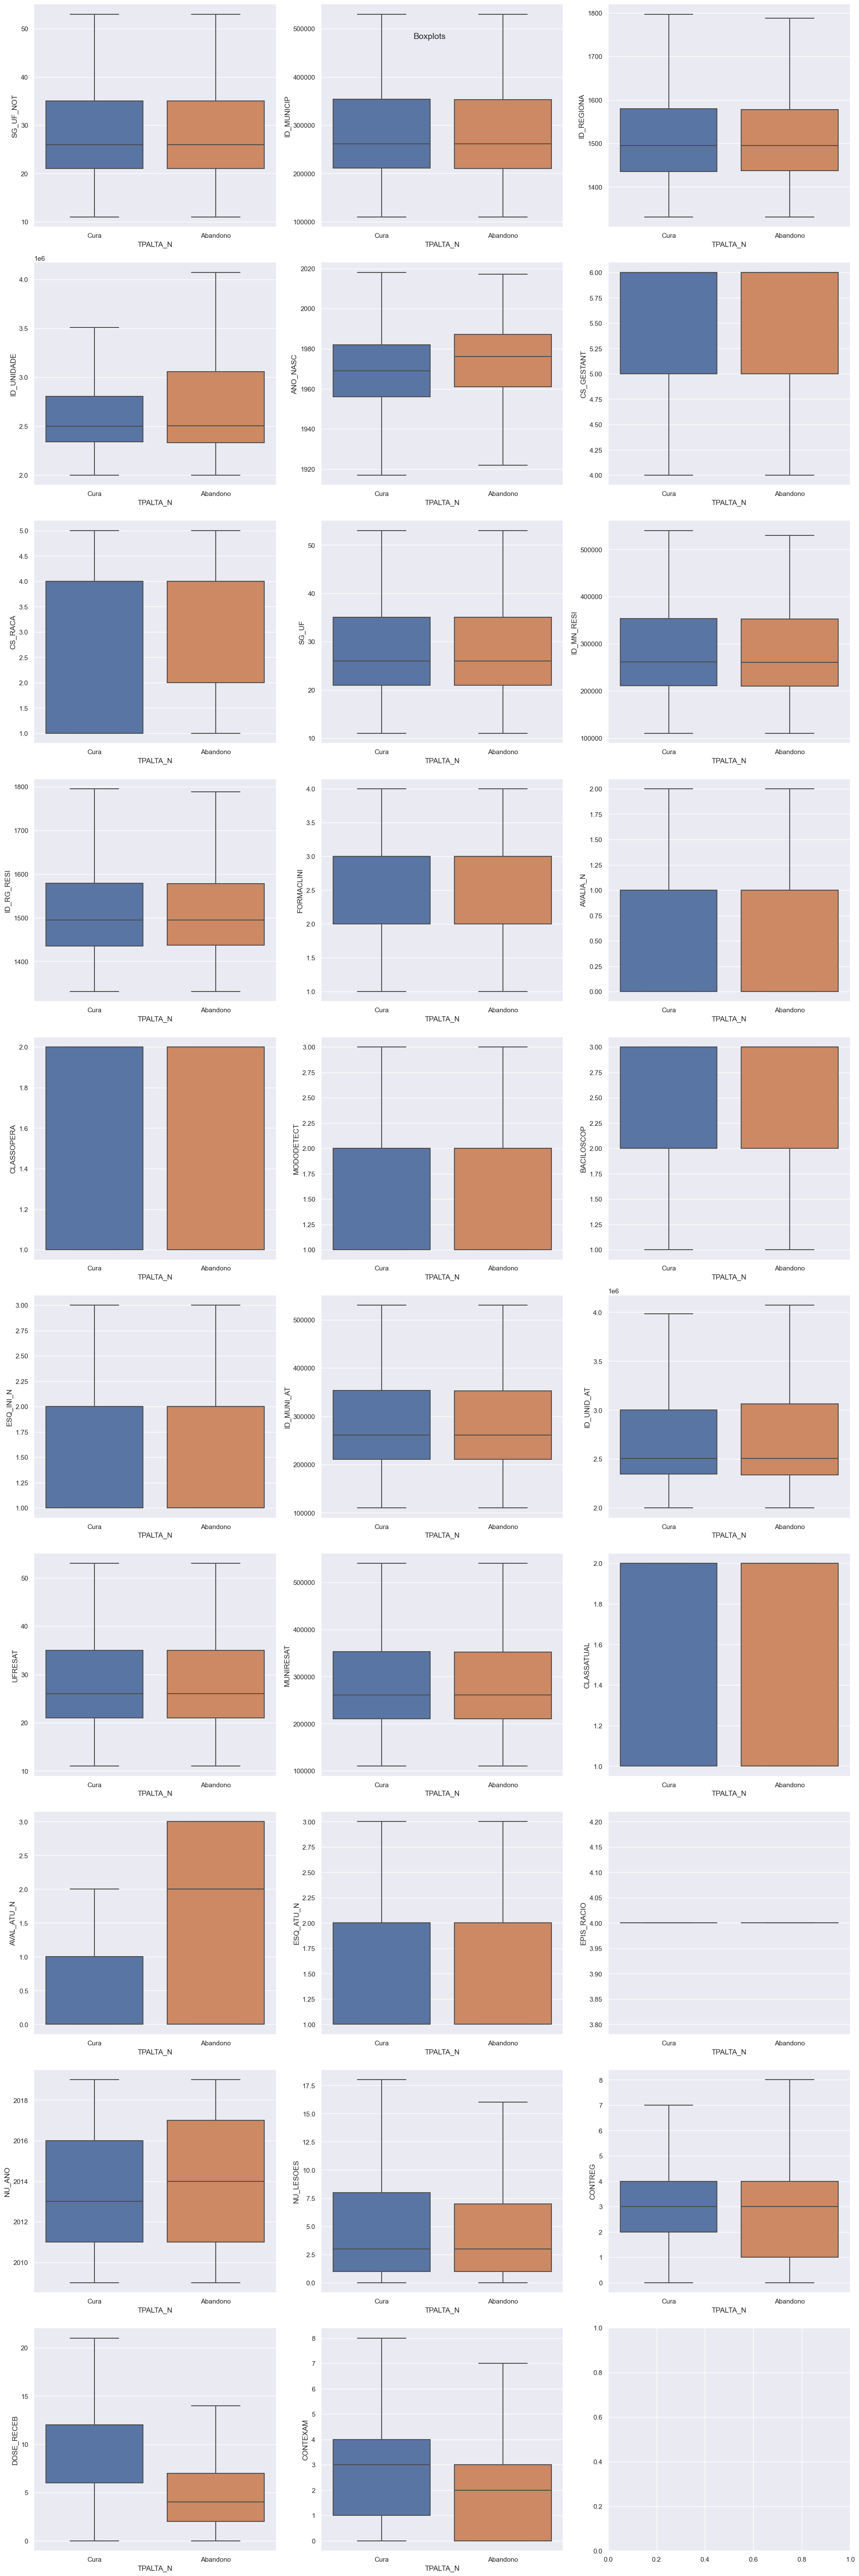

In [76]:
make_subplots(df_hans_outcome, num_feats, target)

In [80]:
num_corr = get_correlations(df_hans_outcome, num_feats, target)
num_corr

,ANOVA_p_value,M.I
DOSE_RECEB,0.000000,0.144570
CLASSATUAL,0.000000,0.051291
CLASSOPERA,0.000000,0.050745
ESQ_INI_N,0.000000,0.049706
CS_RACA,0.000000,0.032981
EPIS_RACIO,0.000000,0.029829
MODODETECT,0.000000,0.029355
ESQ_ATU_N,0.000000,0.025031
CS_GESTANT,0.854442,0.024808
BACILOSCOP,0.000000,0.022325


#### Categorical features

In [138]:
cat_feats = [feat for feat in cat_feats if 'DT' not in feat if target not in feat if 'ID' not in feat if 'ESCOL' not in feat]
cat_feats

['CS_SEXO', 'UFATUAL']

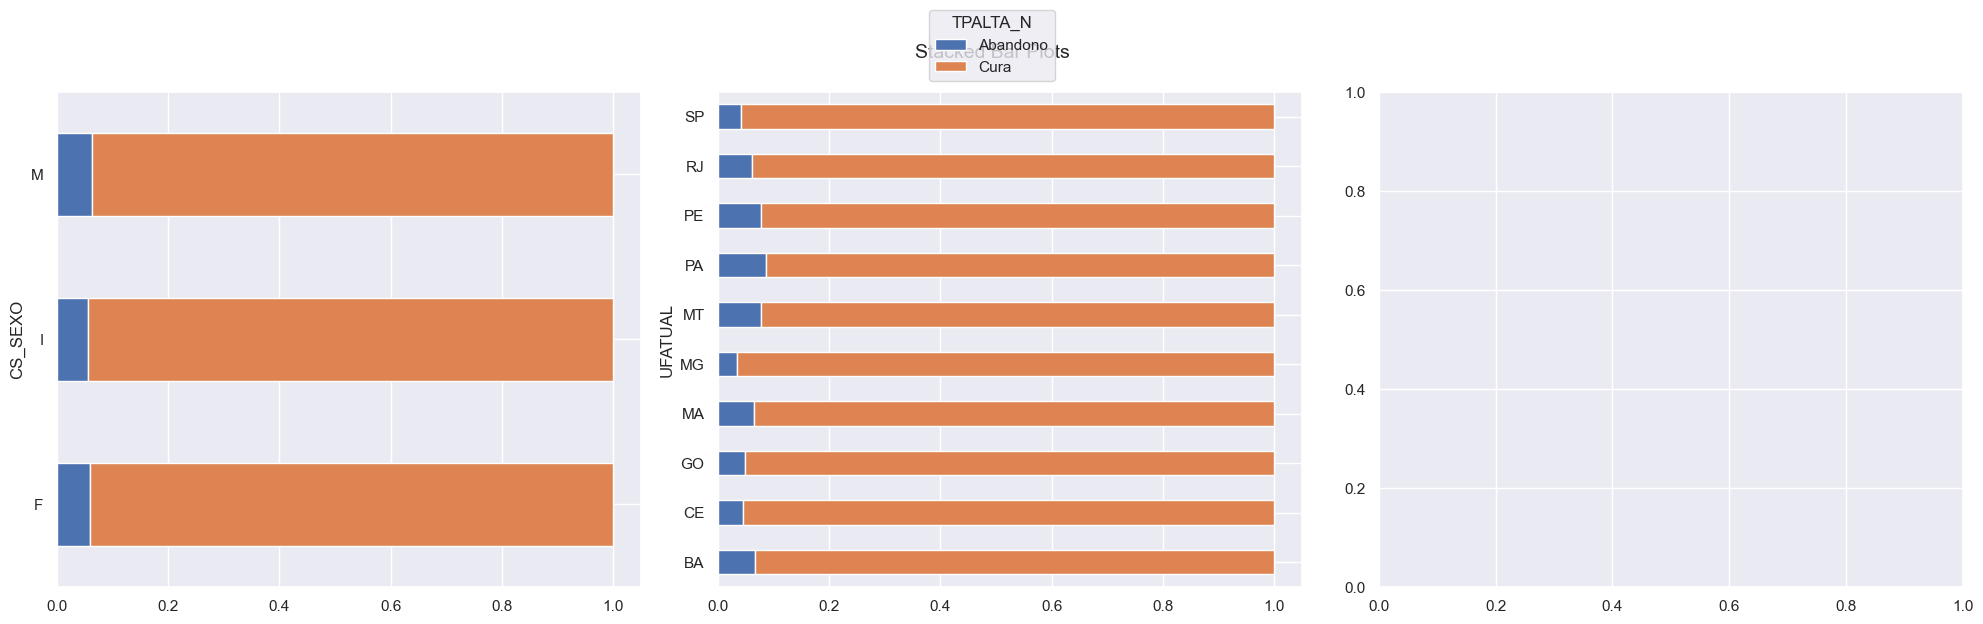

In [140]:
make_subplots(df_hans_outcome, cat_feats, target)

In [139]:
cat_corr = get_correlations(df_hans_outcome, cat_feats, target)
cat_corr

,chi2_p_value,M.I
UFATUAL,0.000000,0.002940
CS_SEXO,0.001759,0.000021


### ML Tests

In [141]:
num_transformer = FeatureUnion(    
    [
        ('num_pipe', Pipeline(
            [
                ('norm', StandardScaler()),
                ('nan_input', SimpleImputer())
            ]
        )),
        ('nan_flag', MissingIndicator(error_on_new=False))
    ]
)
feat_transformer = ColumnTransformer(
    [
        ('num_trans', num_transformer, num_feats),
        ('cat_trans', OneHotEncoder(handle_unknown='ignore'), cat_feats)    
    ],
    remainder='passthrough', sparse_threshold=0
)

In [142]:
X = df_hans_outcome[num_feats + cat_feats].copy()
le = LabelEncoder().fit(df_hans_outcome['TPALTA_N'])
y = le.transform(df_hans_outcome['TPALTA_N'])

#### Random Forest

In [145]:
rf_pipe = Pipeline([('feat_trans', feat_transformer),
                    ('over', RandomOverSampler()),
                    ('rf', RandomForestClassifier(n_estimators=100))
                   ])

In [159]:
preds = cross_val_predict(rf_pipe, X, y, cv=5)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61     18644
           1       0.97      0.98      0.98    285529

    accuracy                           0.96    304173
   macro avg       0.83      0.76      0.79    304173
weighted avg       0.95      0.96      0.95    304173



#### Logistic Regression

In [148]:
lr_pipe = Pipeline([('feat_trans', feat_transformer),
                    ('over', RandomOverSampler()),
                    ('rf', LogisticRegression(max_iter=100))
                   ])

In [156]:
preds = cross_val_predict(lr_pipe, X, y, cv=5)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.35      0.86      0.50     18644
           1       0.99      0.90      0.94    285529

    accuracy                           0.89    304173
   macro avg       0.67      0.88      0.72    304173
weighted avg       0.95      0.89      0.91    304173

